In [131]:
# import libaries
import matplotlib.pyplot as plt
from IPython import display
import matplotlib as mpl
from matplotlib import cm
import geopandas as gpd
import pandas as pd
import math
import json
import numpy as np
from sqlalchemy import create_engine
import bisect
import random
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import time

In [132]:
# load the credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

# create connection string
connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


# Electricitiy Prices (will be replaced with real data later)

In [133]:
electricity_price = np.zeros(96)
electricity_price[:24] = 0.2
electricity_price[24:40] = 0.25
electricity_price[40:44] = 0.22
electricity_price[44:56] = 0.2
electricity_price[56:68] = 0.22
electricity_price[68:84] = 0.25
electricity_price[84:] = 0.22

# Enviorment (will be replaced with Python package later)

In [152]:
class CarsharingEnv(gym.Env):
    def __init__(self, stations, vehicle_information, episode_len = 24, dt=0.25, 
                 cancellation_penalty = 100, penalty_per_kwh = 0.25, v2g = True, 
                 v2g_demand_event = 500, v2g_max_duration = 3.0, v2g_penalty = 10000, 
                 v2g_probability_charging_event = 0.5, v2g_probability_discharging_event = 0.5, 
                 v2g_morning_time_period = [6.0, 9.0, 10.75], v2g_noon_time_period = [11.0, 14.0, 16.0], 
                 v2g_evening_time_period = [16.25, 19.0, 24.0], v2g_reward = 2000,
                 planned_bookings = True, precomputed_bookings = True, max_distance_car_assingment = 5000, plot_state = True):
        """
        Parameters
        ----------
        stations: Geopandas Geodataframe
            Locations of car-sharing stations, including a distinct "station_no" attribute with station ID.
        vehicle_information: Pandas Dataframe
            Includes the features "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category" for each car.
        episode_len: int, optional
            Length of one episode in hours, by default 24.
        dt: float, optional
            Time step size in hours, by default 0.25 (a quarter hour).
        cancellation_penalty: int, optional
            Maximum penalty in CHF for a booking cancelled due to not enough charged battery, by default 100.
        penalty_per_kwh: int, optional
            Penalty in CHF/kWh for total negative energy difference between beginning and ending of episode, by default 0.25.
        v2g: boolean, optional
            Boolean indicating if V2G events take place, by default True.
        v2g_demand_event: int, optional
            Energy demand during V2G event in kWh per time step (dt), by default 500.
        v2g_max_duration: int, optional
            Maximum duration of V2G charging or discharging event in hours, by default 3.
        V2G_penalty: int, optional
            Penalty in CHF if agent charges/discharges less energy than specified in "v2g_demand_event" during V2G event, by default 10000.
        v2g_probability_charging_event: float, optional
            Probability that a charging event will take place around noon, by default 0.5.
        v2g_probability_discharging_event: float, optional
            Probability that a discharging event will take place in the morning or evening, by default 0.5.
        v2g_morning_time_period: list, optional
            List containing: 1) first possible time (hours) for starting v2g discharging event in the morning, by default 6.0 (6 AM).
                             2) last possible time (hours) for starting v2g discharging event in the morning, by default 9.0 (9 AM).
                             3) last possible timestamp for v2g discharging operation, by default 10.75 (10:45 AM).
        v2g_noon_time_period: list, optional
            List containing: 1) first possible time (hours) for starting v2g charging event at noon, by default 11.0 (11 AM).
                             2) last possible time (hours) for starting v2g charging event at noon, by default 14.0 (2 PM).
                             3) last possible timestamp for v2g charging operation, by default 16.0 (4 PM).
        v2g_evening_time_period: list, optional
            List containing: 1) first possible time (hours) for starting v2g discharging event in the evening, by default 16.25 (4:15 PM).
                             2) last possible time (hours) for starting v2g discharging event in the evening, by default 19.0 (7 PM).
                             3) last possible timestamp for v2g charging operation, by default 24 (00:00 AM, next day).
        v2g_reward: int, optional
            Revenue during v2g operations per timestep in CHF, by default 2000 CHF.
        planned_bookings: boolean, optional
            Boolean indicating whether there are planned bookings in the environment; otherwise, all bookings are spontaneous, by default True.
        precomputed_bookings: boolean, optional
            Boolean indicating whether the planned bookings in the environment are precomputed (for massive speed up), by default True.
        max_distance_car_assingment: int, optional
            Maximum search distance in meter for Car-assingment problem, by default 5000.
        plot_state: boolean, optional
            Plot current state of enviorment or not, by defualt True.
        ----------
        Observation space: 5 parts:
        1) Location for each car (three options):
            - Station number (1000-5000)
            - Reservation number (2x'xxx'xxx) during trip
            - Reservation number (3x'xxx'xxx) during relocation
            - -1 if car is not available
        2) State of charge (SOC) for each vehicle (between 0 and 1).
        3) Timestamp of the next planned booking for each car (discrete between 0 and self.episode_len).
        4) Duration of the next planned booking (measured in the number of time steps of length self.dt).
        5) Binary variable indicating the occurrence of a vehicle-to-grid (V2G) event.
        Remark: States 3) and 4) are only included if the variable "planned_bookings" is True.
        ----------
        Action space: 3 actions for each car:
        1) 0 = do nothing.
        2) 1 = charging.
        3) 3 = discharging (V2G).
        """
        self.initialization_ = 0
        self.planned_bookings_ = 0
        self.car_assingment_ = 0
        self.charging_ = 0
        self.reward_ = 0
        self.v2g_ = 0
        
        
        
        # environment settings
        self.dt = dt
        self.episode_len = int(episode_len / self.dt) 
        self.planned_bookings = planned_bookings
        self.precomputed_bookings = precomputed_bookings
        self.max_distance_car_assingment = max_distance_car_assingment
        self.plot_state = plot_state
        
        # stations in system
        self.stations = stations
        
        # vehicle information
        self.vehicles_id = vehicle_information["vehicle_no"]
        self.nr_vehicles = len(self.vehicles_id)
        self.chariging_power = np.full_like(vehicle_information["charge_power"], min(vehicle_information["charge_power"])) 
        self.battery_capacities = vehicle_information["battery_capacity"] 
        self.vehicle_type = vehicle_information["vehicle_category"] 
        
        # V2G 
        self.v2g = v2g
        self.v2g_demand_event = v2g_demand_event
        self.v2g_max_duration = v2g_max_duration / self.dt
        self.v2g_penalty = v2g_penalty
        self.v2g_probability_charging_event = v2g_probability_charging_event
        self.v2g_probability_discharging_event = v2g_probability_discharging_event
        self.v2g_morning_time_period = v2g_morning_time_period
        self.v2g_noon_time_period = v2g_noon_time_period
        self.v2g_evening_time_period = v2g_evening_time_period
        self.v2g_reward = v2g_reward
        
        # penalties
        self.cancellation_penalty = cancellation_penalty
        self.penalty_per_kwh = penalty_per_kwh
        
        # define observation space:
        if self.planned_bookings is True:
            self.observation_space = gym.spaces.Dict({
                'car_features': gym.spaces.Box(
                    low=np.array([-1, 0, -1, -1] * self.nr_vehicles),
                    high=np.array([9999999, 1, 96, 100] * self.nr_vehicles),
                ),
                'v2g_event_feature': gym.spaces.Discrete(3)
            })
        else: 
            self.observation_space = gym.spaces.Dict({
                'car_features': gym.spaces.Box(
                    low=np.array([-1, 0] * self.nr_vehicles),
                    high=np.array([9999999, 1] * self.nr_vehicles)
                ),
                'v2g_event_feature': gym.spaces.Discrete(3)
            })
        
    
        # action space
        self.action_space = spaces.MultiDiscrete([3 for _ in range(self.nr_vehicles)])
        
        # define state boundaries for slicing list
        # locations upper bound
        self.locations_upper = self.nr_vehicles
        # soc upper bound
        self.soc_upper = 2*self.nr_vehicles
        if planned_bookings is True:
            # locations, upper bound:
            self.reservation_time_upper = self.nr_vehicles * 3
            self.v2g_lower = self.nr_vehicles * 4
            
            

        else:
            # locations, upper bound:
            self.v2g_lower = self.nr_vehicles * 2
            
       
        
        
        #sql = "SELECT reservation_no FROM mobility.service_reservation"
        #test = pd.read_sql(sql, engine)
        #self.test = test
        
    def reset(self, daily_data, reservations, planned_reservations= None, planned_durations = None):
        """
        Parameters
        ----------
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Contains information about the cars, including "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category".

        Returns
        ----------
        self.state: numpy ndarray
            The reset state of the environment at the first time step. It includes the following information for each car:
            1) Location:
                - Station number (1000-5000)
                - Reservation number (2x'xxx'xxx) during trip
                - Reservation number (3x'xxx'xxx) during relocation
                - -1 if the car is not available
            2) State of charge (SOC) for each vehicle (between 0 and 1).
            3) Timestamp of the next planned booking for each car (discrete value between 0 and self.episode_len).
            4) Duration of the next planned booking (measured in the number of time steps of length self.dt).
            5) Binary variable indicating the occurrence of a vehicle-to-grid (V2G) event.
            Note: The information in 3) and 4) is included only if the variable "planned_bookings" is True.
        """
        
        # set time to 0
        self.t = 0
        
        # reset reward lists 
        self.reward_list_trips = []
        self.reward_list_charging = []
        self.reward_list_cancellation_penalty = []
        self.reward_list_v2g = []
        self.reward_list = []
        
        # reset state
        self.state_old = np.zeros(self.nr_vehicles * 4 + 1)
        
        # reset planned reservations:
        self.planned_reservations_car = {key: [] for key in self.vehicles_id}
        
        # get random v2g events
        self.get_random_v2g_events()
        
        
        ### initialize state at t = 0 ###
        
        # 1) car locations (three options)
        car_locations = daily_data.iloc[:,0].values
        
        # 2) SOC (state of charge) ##
        #car_SOC = np.random.rand(self.nr_vehicles) # random values between 0-100%
        #car_SOC = np.zeros(self.nr_vehicles) # all car batteries empty (0%)
        #car_SOC = np.full((self.nr_vehicles,), 0.2) # all car batteries at 20%
        #car_SOC = np.random.uniform(low=0.5, high=1, size=self.nr_vehicles) # All cars randomly between 50-100%
        np.random.seed(42)
        rng = np.random.RandomState(42)
        car_SOC = rng.uniform(low=0.5, high=1, size=self.nr_vehicles)
        
         # state 5) Binary V2G event
        v2g_event = np.array([0])
 
        # final state with planned bookings
        if self.planned_bookings is True:
            if self.precomputed_bookings is True:
                next_reservation = planned_reservations.iloc[:,0].values
                duration_next_reservation = planned_durations.iloc[:,0].values
            else:
                # 3) timestamp of next planned reservation 
                # 4) Duration of next planned reservation
                next_reservation, duration_next_reservation = self.update_reservation_state(reservations, True)

            # concatinate states 1-5
            self.state = np.concatenate([car_locations, car_SOC, next_reservation, duration_next_reservation, v2g_event])
        else:
            self.state = np.concatenate([car_locations, car_SOC, v2g_event])
        
        # save energy at beginning of episode (relevant for reward)
        self.energy_beginning = sum(car_SOC * self.battery_capacities)

        return self.state

    def get_random_v2g_events(self):
        
        self.v2g_discharing_morning_start = -1
        self.v2g_discharing_morning_end = -1
        self.v2g_charing_noon_start = -1
        self.v2g_charing_noon_end = -1
        self.v2g_discharing_evening_start = -1
        self.v2g_discharing_evening_end = -1
        
        if self.v2g is True:
            # morning discharging event:
            if int(random.random() < self.v2g_probability_discharging_event) == 1:
                # get random start time between 6 and 9 am
                self.v2g_discharing_morning_start = round(random.uniform(self.v2g_morning_time_period[0], self.v2g_morning_time_period[1]) / 0.25) * 0.25 / self.dt
                self.v2g_discharing_morning_end = min(self.v2g_morning_time_period[2] / self.dt, self.v2g_discharing_morning_start + round(random.uniform(0.25, self.v2g_max_duration) / 0.25) * 0.25 / self.dt)
            
            # noon charging event
            if int(random.random() < self.v2g_probability_charging_event) == 1:
                # get random start time between 6 and 9 am
                self.v2g_charing_noon_start = round(random.uniform(self.v2g_noon_time_period[0], self.v2g_noon_time_period[1]) / 0.25) * 0.25 / self.dt
                self.v2g_charing_noon_end = min(self.v2g_noon_time_period[2] / self.dt, self.v2g_charing_noon_start + round(random.uniform(0.25, self.v2g_max_duration) / 0.25) * 0.25 / self.dt)
            
            # evening discharging event
            if int(random.random() < self.v2g_probability_discharging_event) == 1:
                # get random start time between 6 and 9 am
                self.v2g_discharing_evening_start = round(random.uniform(self.v2g_evening_time_period[0], self.v2g_evening_time_period[1]) / 0.25) * 0.25 / self.dt
                self.v2g_discharing_evening_end = min(self.v2g_evening_time_period[2]/ self.dt,self.v2g_discharing_evening_start + round(random.uniform(0.25, self.v2g_max_duration) / 0.25) * 0.25 / self.dt)
        
        return
    
    def update_reservation_state(self, reservations, reset):
        """
         Parameters
        ----------
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_daytime", "vehicle_no", "reservationfrom_daytime", and "reservation_duration" for each reservation.
        reset: boolean, optional
            Boolean indicating whether to reset the environment or not.
            
        Returns
        ----------
        next_reservation : numpy ndarray
            Timestamp of the next planned booking for each car (discrete value between 0 and self.episode_len).
        duration_next_reservation : numpy ndarray
            Duration of the next planned booking (measured in the number of time steps of length self.dt).
        """

        # initalize variables if during reset of environment
        if reset is True:
            time = 0
            next_reservation = np.ones(self.nr_vehicles) * -1
            duration_next_reservation = np.ones(self.nr_vehicles) * -1
            
        # get current state of next planned reservations (timestamp and duration)
        else:
            time = self.t + 1
            next_reservation = self.state[self.soc_upper : self.reservation_time_upper]
            duration_next_reservation = self.state[self.reservation_time_upper :self.v2g_lower]
            
        # filter reservations: 
        # bookings before t = 0 have value syscreatedate_daytime = 0
        reservations_t =  reservations[reservations["syscreatedate_daytime"] == time]
        

        # iterate over all vehicles, search planned reservations
        count = 0
        for vehicle_id in self.vehicles_id:  
            # get reservation of car
            current_car = reservations_t[reservations_t["vehicle_no"] == vehicle_id]


            # remove reservations in past
            if len(self.planned_reservations_car[vehicle_id]) != 0:
                if int(self.planned_reservations_car[vehicle_id][0][0]) <= self.t:
                    self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]

            # skip if no new reservation found
            if len(current_car) == 0:
                
                # if current state's reservation is in the past 
                if next_reservation[count] <=  self.t and next_reservation[count] != -1:
                    
                    # check for planned reservations saved in the past
                    if len(self.planned_reservations_car[vehicle_id]) != 0:
                        # save reservation timestamp
                        next_reservation[count] = self.planned_reservations_car[vehicle_id][0][0]

                        # save reservation duration
                        duration_next_reservation[count] = self.planned_reservations_car[vehicle_id][0][1]

                        # remove reservation from dict with planned reservations
                        self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]

                    else:
                        # assign -1 for no planned reservation
                        next_reservation[count] = -1
                        duration_next_reservation[count] = -1
                count +=1

                continue

            for i in range(0,len(current_car)):    
                
                # get timestamp and duration of next planned reservation
                reservation_time = current_car["reservationfrom_daytime"].iloc[i]
                reservation_duration = current_car["reservation_duration"].iloc[i]
                
                # save directly if during reset of environment
                if i == 0 and reset is True:
                    # save timestamp of next reservation
                    next_reservation[count] = reservation_time

                    # save reservation duration
                    duration_next_reservation[count] = reservation_duration


                if reset is True:
                    # save directly first reseration during reset of environment
                    if i == 0 and reset is True:
                        # save timestamp of next reservation
                        next_reservation[count] = reservation_time

                        # save reservation duration
                        duration_next_reservation[count] = reservation_duration
                    
                    # save other found reservation during reset of environment in dict
                    else:
                        new_reservation = [reservation_time, reservation_duration]

                        # remain order in dict (nearest reservation in first index)
                        index = bisect.bisect_left([sublist[0] for sublist in  self.planned_reservations_car[vehicle_id]], new_reservation[0])

                        # save timestamp and duration of new but later reservations in dict
                        self.planned_reservations_car[vehicle_id].insert(index, new_reservation)
                
                else: 
                    # save found reservation environment in dict
                    new_reservation = [reservation_time, reservation_duration]
                    
                    # remain order in dict (nearest reservation in first index)
                    index = bisect.bisect_left([sublist[0] for sublist in  self.planned_reservations_car[vehicle_id]], new_reservation[0])
                    
                    # save timestamp and duration of new but later reservations in dict
                    self.planned_reservations_car[vehicle_id].insert(index, new_reservation)

            # update only if reservation is before last planned reservation
            if  reset is False and self.planned_reservations_car[vehicle_id][0][0] <  next_reservation[count]:
                # save timestamp of next reservation
                next_reservation[count] = self.planned_reservations_car[vehicle_id][0][0]

                # save reservation duration
                duration_next_reservation[count] = self.planned_reservations_car[vehicle_id][0][1]

                # remove reservation from dict
                self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]
                
            count += 1
        
        return next_reservation, duration_next_reservation
    
    def cancel_trips_low_SOC(self, daily_data, reservations):
        """
        Parameters
        ----------
       daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Contains information about the cars, including "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category".

        Returns
        ----------
        penalty_counter: int
            Total factor of penalty for timestep.
        """

        # check if car booked or not (start of booking)
        on_trip = self.state[:self.locations_upper] > 1000000
        trip_start = self.state[:self.locations_upper] != self.state_old[:self.locations_upper]
        result = on_trip & trip_start
        on_trip_indices = np.where(result)[0].tolist()

        
        ### check if engough energy charged for booked trip (otherwise trips needs to be cancelled) ###
        
        # array with 0 for all car that do not start a new trip, otherwise 1
        soc_needed = np.zeros(len(result))
        
        # iterate over indices of cars that start a trip
        for trip_start in on_trip_indices:
            reservation_no = self.state[trip_start]
            if reservation_no >= 30000000:
                # todo: implement relocations
                pass
            else:
                try:
                    # calculate needed SOC for trip
                    soc_needed[trip_start] = reservations[reservations["reservation_no"] == reservation_no]["required_soc"].iloc[0] / 100
 
                except Exception as E:
                    print("")
                    print(E)
                    print("reservation no")
                    print(reservation_no)
                    print(self.state[trip_start])
                    print("station_no")
                    print(self.state_old[trip_start])
                    print("vehicle id")
                    print(self.vehicles_id[trip_start])
            
        # calculate difference between SOC of car at the moment and needed SOC for starting the trip
        difference_energy = self.state[self.locations_upper:self.soc_upper] - soc_needed
      
        # boolean array, True for cars with to low SOC for trip (those reservations will be cancelled)
        cancelled_trips = difference_energy < 0
        
        # booolean array, True for cars without cancelled trip
        not_cancelled_trips = np.logical_not(cancelled_trips)
        
        # convert to integer array
        not_cancelled_trips_int = not_cancelled_trips.astype(int)
        
        # calculate new SOC of cars (previous timestamps SOC minus SOC needed for trip)
        self.state[self.locations_upper:self.soc_upper] = (self.state[self.locations_upper:self.soc_upper] - soc_needed * not_cancelled_trips_int) 

        # get indices of cars with cancelled reservation because of low battery level
        indices = np.where(cancelled_trips)[0]
        
        # count number of cancellation, used for reward penalty
        penalty_counter = 0
 

        ### remove cancelled booking from discrete tables (if reservation is cancelled, the car is again available) ###
        ### assign bookings to other cars if possible ###
    
        # iterate over indices of cars with cancelled reservations
        for index in indices:
            found = False
            last_station = 0
            t = self.t
            
            # defualt car location if last location not found
            car_location = -1
            
            while not found:
                # search last station of car in bookings, replace reservation number with last location
                if t > 0:
                    car_location = daily_data.iloc[index, t]
                    if car_location >= 1000 and car_location <= 6000:
                        found = True
                        
                        # assign cancelled reservation to other avaiable car if possible, get cancellation penalty
                        penalty_counter += self.car_assignment(car_location, daily_data, reservations, index, soc_needed)
                else:
                    # if no station found back in time, stop loop
                    found = True
                t = t - 1
                
            # update current state of car with actual location
            self.state[:self.locations_upper][index] = car_location
            
            # remove reservation from dataset
            changed = False

            # iterate over row in discrete table of given car
            for col_index, col_data in enumerate(daily_data.iloc[index]):

                
                # remove reservation, replace reservation number by car location
                if col_index >= self.t + 1 and daily_data.iloc[index, col_index] >= 1000000:
                    daily_data.iat[index, col_index] = car_location
                    changed = True
                
                # stop loop if reservation cancelled
                elif col_index >= self.t and daily_data.iloc[index, col_index] < 1000000 and changed == True:
                    break
        
        # return total cancellation penalty
        return penalty_counter
    
    def car_assignment(self, station_id, daily_data, reservations, index_car, soc_needed):
        """
        Parameters
        ----------
        station_id: int
            ID of station with the cancelled reservation.
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Contains information about the cars, including "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category".
        index_car: int
            Index of the car with the cancelled reservaton
        soc_needed: int
            Minimum needed SOC for cancelled trip.

        Returns
        ----------
        penalty_counter: int
            Penalty of single cancelled reservation
        """

        # create local copy of station table
        stations_processing = self.stations.copy()
        
        #################### todo: problem at 23:45 timestamp ####################################

        # look for cars at the same station as cancelled reservation
        filtered_df = daily_data.loc[daily_data.iloc[:, self.t + 1] == station_id]
        
        # get cancelled reservation
        # if end of day (00:00)
        reservations_of_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index_car]) & (reservations["reservation_no"] == daily_data.iloc[index_car, self.t + 1])]
       
        # if no reservation found
        if len(reservations_of_car) == 0:
            print("")
            print("Reservation in Discrete table not found in Reservation table")
            print("Station ID")
            print(station_id)
            print("Car ID")
            print(self.vehicles_id[index_car])
            print("Reservation_number")
            print(daily_data.iloc[index_car, self.t + 1])
   
            
            # return zero penalty
            return 0
        
        # get cancelled reservation duration
        reservation_duration = reservations_of_car["reservation_duration"].iloc[0]
        
        # get cancelled reservation number
        reservation_no = reservations_of_car["reservation_no"].iloc[0]
        
        # get geodata of station with cancelled reservation
        station = stations_processing[stations_processing["station_no"] == station_id]
        
        # car type of cancelled car
        car_type_cancelled = self.vehicle_type[index_car]
        
        # search available cars at stations in the neigbourhood of the cancelled reservation's car
        solution_found = False
        while solution_found is not True:
            # perform the nearest neighbor join for getting nearest distance
            joined = gpd.sjoin_nearest(station, stations_processing, distance_col = "distance_stations", max_distance = self.max_distance_car_assingment)
            
            # no station found within 5km distance
            if len(joined) == 0:
                solution_found = True
                
                # return maximum penalty
                penalty = 1
                break
                
            # get station ID of nearest found station
            alternative_station_ID = joined["station_no_right"].iloc[0]
            
            # get IDs of cars at nearest found station
            cars_at_found_station = self.state[:self.locations_upper] == alternative_station_ID
            indices = np.where(cars_at_found_station)[0] 
            
            # iterate over found cars
            for index in indices:
                number_reservations = 0
                if self.planned_bookings is True:
                    # search for reservations during time period of cancelled reservation
                    reservations_of_found_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index]) & (reservations["reservationfrom_daytime"] >= self.t + 1) & (reservations["reservationfrom_daytime"] <= self.t + 1 + reservation_duration) & (reservations["syscreatedate_daytime"] <= self.t + 1)] 
                    number_reservations = len(reservations_of_found_car)

                # if alternative car available (no reservation yet) and SOC high enough for trip
                if number_reservations == 0 and (self.state[self.locations_upper:self.soc_upper][index] - soc_needed[index_car]) >= 0 and self.state[:self.locations_upper][index] >= 1000 and self.state[:self.locations_upper][index] <= 1000000 and car_type_cancelled == self.vehicle_type[index]:
                    solution_found = True
                    changed = False
                    
                    # calculate distance weighted penalty (zero if car aviailable at the same station)
                    penalty = joined["distance_stations"].iloc[0]/5000 
                    
                    # update discrete table of found car 
                    for col_index, col_data in enumerate(daily_data.iloc[index]):
                        
                        ############ overlapping if reservation only in discrete table? ############
                        
                        # add reservation to discrete table
                        if col_index > self.t + 1 and col_index <= self.t + 1 + reservation_duration:
                            daily_data.iat[index, col_index] = reservation_no                    
                    
                        # add SOC to discrete table
                        elif col_index == self.t + 1:
                            daily_data.iat[index, col_index] = reservation_no     

                            # remove used SOC during trip from vehicle state
                            self.state[self.locations_upper+ index] = (self.state[self.locations_upper + index] - soc_needed[index_car]) 
                        
                            # update state
                            self.state[index] = reservation_no
                            
                            
                        # end of reservation time period
                        elif col_index > self.t + 1 + reservation_duration:
                            break
                            
                    # stopp searching for alternative car if a solution is already found
                    break
                    
            # remove already checked station for next iteration
            if len(joined) != 0:
                stations_processing = stations_processing[stations_processing.station_no != joined["station_no_right"].iloc[0]]
                                
        # return penalty of cancellation
        return penalty
    
    def charging(self, action, not_chargable):
        
        ############ todo: implement charging function ############
    
        # filter charging action
        charging_action = np.zeros_like(action)
        charging_action[action == 1] = 1
        
        # energy (in kWh) charged per vehicle:
        energy_to_charge = charging_action * self.chariging_power.tolist() * self.dt
        #energy_to_charge = charging_action * POWER_charge * self.dt
       
        # can only charge until capacity is reached
        currently_charged = self.battery_capacities.tolist() * self.state[self.locations_upper:self.soc_upper]

        energy_to_charge = np.minimum(energy_to_charge, self.battery_capacities.tolist() - currently_charged)
       
        # can only charge cars that are at the station
        energy_to_charge[not_chargable] = 0
    
        return energy_to_charge 
    
    def discharging(self, action, not_chargable):
        
        ############ todo: implement discharging function ############
        
        # filter charging action
        discharging_action = np.zeros_like(action)
        discharging_action[action == 2] = 1
        
        # energy (in kWh) discharged per vehicle:
        energy_to_discharge = discharging_action * self.chariging_power.tolist() * self.dt
        
        # can only discharge until battery is empty
        currently_charged = self.battery_capacities.tolist() * self.state[self.locations_upper:self.soc_upper]
        energy_to_discharge = -np.minimum(energy_to_discharge, currently_charged)
        
        # can only discharge cars that are at the station
        energy_to_discharge[not_chargable] = 0

        return energy_to_discharge
    
    
    
    def update_SOC_charging(self, energy_to_charge):    
        self.state[self.locations_upper:self.soc_upper] += energy_to_charge / self.battery_capacities
        
        return 
    
    def update_SOC_discharging(self, energy_to_discharge):
        # update SOC state
        self.state[self.locations_upper:self.soc_upper] += energy_to_discharge / self.battery_capacities
        
        return 
    

    def compute_reward(self, energy_to_charge, energy_to_discharge, penalty_counter, reservations, electricity_price):
        ############ todo ############ 
        ############ trip revenue from database ############
        ############ cancellation penalty distance weigthed (car assingment) ############
        ############ penalty for full charging or empty discharging ############
        skip = False
        # check if car on trip
        #on_trip = (self.state[:self.locations_upper] >= 0) & (
        #            self.state[:self.locations_upper] <= 100)
        #on_trip_indices = np.where(on_trip)[0].tolist()
        
        on_trip = self.state[:self.locations_upper] > 1000000
        trip_start = self.state[:self.locations_upper] != self.state_old[:self.locations_upper]
        result = on_trip & trip_start
        on_trip_indices = np.where(result)[0].tolist()
        
        sum_reward_trip = 0

        for trip_start in on_trip_indices:
            reservation_no = self.state[trip_start]
            if reservation_no >= 30000000:
                pass
            else:
                try:
                    duration_reward = reservations[reservations["reservation_no"] == reservation_no]["revenue_duration"].iloc[0]
                    distance_reward = reservations[reservations["reservation_no"] == reservation_no]["revenue_distance"].iloc[0]
                    total_reward_trip = duration_reward + distance_reward
                    sum_reward_trip += total_reward_trip 
                    
                    
                                
                    #test = self.test[self.test["reservation_no"]==reservation_no]
                    #if len(test) > 0:
                        #print("xxxxxxxxxxxx Service Reservation xxxxxxxxxxxxxx")
                        #print(self.t)
                        #print(reservation_no)

                    
                    
                    if duration_reward is None:
                        print("")
                        print("duration null:")
                        print(reservation_no)
                    if distance_reward is None:
                        print("")
                        print("distance null:")
                        print(reservation_no)
                except Exception as E:
                    print("")
                    print(E)
                    print("reservation no")
                    print(reservation_no)
                    print(self.state[trip_start])
                    print("station_no")
                    print(self.state_old[trip_start])
                    print("vehicle id")
                    print(self.vehicles_id[trip_start])
                    


        ### compute reward ###
        # cacluate charging costs
        rew_charging = np.sum(-1 * energy_to_charge * electricity_price[self.t])
        
        # calculate discharging revenue
        #rew_discharging = -np.sum(1 * energy_to_discharge * electricity_price[self.t])
        
        # trip revenue (duration + driven distance)
        on_trip_numerical = np.where(on_trip, 1, 0)
                
        # penalty for cancelled reservation, because of flat batteries
        reward_cancellations = -self.cancellation_penalty * penalty_counter
        
        # reward from V2G
        v2g_reward = 0
        if self.state[self.v2g_lower:] == 1: 
            v2g_reward = self.v2g_reward
        
        # penalty if not enough discharge for V2G
        if self.state[self.v2g_lower:] == 1 and abs(sum(energy_to_discharge)) < self.v2g_demand_event:

            v2g_reward -= self.v2g_penalty
            
        if self.state[self.v2g_lower:] == 2 and sum(energy_to_charge) < self.v2g_demand_event:
  
            v2g_reward -= self.v2g_penalty
        
        # reward from cancelled reservations (0 distance)
        cancelled_revenue = reservations[(reservations["drive_km"] == 0) & (reservations["reservationfrom_daytime"] == self.t)]["revenue_duration"].sum()
        
        rew_energy_difference = 0
        if self.t == (self.episode_len - 2):
            difference_enery = sum(self.state[self.locations_upper:self.soc_upper] * self.battery_capacities) - self.energy_beginning
            difference_enery = min(difference_enery, 0)
            rew_energy_difference = difference_enery * self.penalty_per_kwh
        
        # total reward
        rew = rew_charging + sum_reward_trip + reward_cancellations + rew_energy_difference + cancelled_revenue + v2g_reward
        
        # save rewards for analysis
        self.reward_list.append(rew)
        self.reward_list_trips.append(sum_reward_trip + cancelled_revenue)
        self.reward_list_charging.append(rew_charging)
        self.reward_list_cancellation_penalty.append(reward_cancellations)
        self.reward_list_v2g.append(v2g_reward)

        return rew
    

    def step(self, action, daily_data, reservations, electricity_price, planned_reservations = None, planned_durations = None):
        ############ todo ############
        ############ include next trip in state ############ 
        start = time.time()
        self.state_old = self.state.copy()
        
        # cars cannot be returned from trips with negative loaded battery, set them zero
        #self.state[self.locations_upper:self.soc_upper][self.state[self.locations_upper:self.soc_upper] < 0] = 0
        
        assert len(self.state[self.locations_upper:self.soc_upper][self.state[self.locations_upper:self.soc_upper] < 0]) == 0, "Vehicle SOC is wrong."
        
        # get current car locations
        car_locations = daily_data.iloc[:, self.t + 1].values

        # update state of car locations
        self.state[:self.locations_upper] = car_locations
        
        end = time.time()
        self.initialization_ += (start - end)
        start = time.time()
        

        if self.planned_bookings is True:
            if self.precomputed_bookings is True:
                    next_reservation = planned_reservations.iloc[:,self.t + 1].values
                    duration_next_reservation = planned_durations.iloc[:,self.t + 1].values
                    self.state[self.soc_upper : self.reservation_time_upper] = next_reservation
                    self.state[self.reservation_time_upper :self.v2g_lower] = duration_next_reservation
            else:
            # update state of reservations (timestamp and duration)
                next_reservation, duration_next_reservation = self.update_reservation_state(reservations, False)
                self.state[self.soc_upper : self.reservation_time_upper] = next_reservation
                self.state[self.reservation_time_upper :self.v2g_lower] = duration_next_reservation

        end = time.time()

        self.planned_bookings_ += (start - end)
        start = time.time()
        
        #print(self.planned_reservations_car)

        
        #self.update_state_next_reservations(last_timestamp, reservations, end_of_week)
       
        # cancel reservations if SOC to low for booked trip and update SOC
        penalty_counter = self.cancel_trips_low_SOC(daily_data, reservations)
        
        
        end = time.time()

        self.car_assingment_ += (start - end)
        start = time.time()

        # check if car usable for charging or discharging
        not_chargable = (self.state[:self.locations_upper] < 1000) | (self.state[:self.locations_upper] > 6000)
        
        # calculate energy needed for charging and discharging
        energy_to_charge = self.charging(action, not_chargable)
        energy_to_discharge = self.discharging(action, not_chargable)
        
        end = time.time()

        
        # cacluate total SOC difference for each car
        energy_difference = np.add(energy_to_charge, energy_to_discharge)
        
        # update SOC state
        self.update_SOC_charging(energy_to_charge)
        self.update_SOC_discharging(energy_to_discharge)
        

        self.charging_ += (start - end)
        start = time.time()
        
        # compute reward
        rew = self.compute_reward(energy_to_charge, energy_to_discharge, penalty_counter, reservations, electricity_price)
        
        end = time.time()

        self.reward_ += (start - end)
        start = time.time()
        
        # update V2G event state
        if self.t + 2 >= self.v2g_discharing_morning_start and self.t + 1 < self.v2g_discharing_morning_end:
            self.state[self.v2g_lower:]  = 1

        elif self.t + 2 >= self.v2g_charing_noon_start and self.t + 1 < self.v2g_charing_noon_end:
            self.state[self.v2g_lower:]  = 2

        elif self.t + 2 >= self.v2g_discharing_evening_start and self.t + 1 < self.v2g_discharing_evening_end:
            self.state[self.v2g_lower:]  = 1

        else:
            self.state[self.v2g_lower:]  = 0
        
        end = time.time()

        self.v2g_ += (start - end)
        start = time.time()
        

        
        done = True if self.t == (self.episode_len - 2) else False
        # update time step
        self.t += 1
        
        

        return self.state, rew, daily_data, done, {}

    def render(self, daily_data):
        #print(f"-------- State at time {self.t} --------")
        #print(f"-------- State at time {daily_data.columns[self.t]} --------")

        # print("vehicle ID:", self.vehicles_id)
        # print("at station:", self.state[: self.nr_vehicles])
        # print("SOC       :", np.around(self.state[self.nr_vehicles :], 2))
        
        if self.plot_state is True:
            timestamp = daily_data.columns[self.t]

            # plot location of vehicles
            on_trip = (self.state[:self.locations_upper] >= 1000000) | (self.state[:self.locations_upper] >= 0) & (
                        self.state[:self.locations_upper] <= 100)
            at_station = (self.state[:self.locations_upper] >= 1000) & (self.state[:self.locations_upper] <= 6000)
            count_trip = np.sum(on_trip == True)
            count_at_station = np.sum(at_station == True)
            categories = ["At Station", "On Trip"]
            values = [count_at_station, count_trip]
            fig, ax = plt.subplots(figsize=(4, 2))
            ax.bar(categories, values)
            plt.ylabel("Numer of Cars")
            plt.title("Location of Cars ({})".format(timestamp))
            plt.xticks(rotation=90)

            plt.show()

            self.render_soc()

        
    def render_soc(self):
        soc = self.state[self.locations_upper:self.soc_upper]
        
        side_size = int(np.sqrt(self.nr_vehicles))
        img_w, img_h = side_size, side_size+1
        assert img_w * img_h > self.nr_vehicles
        img = np.zeros((img_w * img_h, 4))
        at_station = np.zeros(img_w * img_h)
        at_station[:self.nr_vehicles] = self.state[:self.locations_upper]

        img[:self.nr_vehicles] = np.array([my_cmap(val) for val in soc])
        img[at_station < 0] = np.array([0.8, 0.8, 0.8, 1])
        img[at_station > 10000000] = np.array([0.8, 0.2, 0.1, 1])
        
        show_soc(img.reshape((img_h, img_w, 4)))

    def episode_summary_statistics(self, daily_data):
        # get data
        date = daily_data.columns[1][:10]
        rew_trips = sum(self.reward_list_trips)
        rew_charging = sum(self.reward_list_charging)
        rew_cancellation = sum(self.reward_list_cancellation_penalty)
        rew_v2g = sum(self.reward_list_v2g)
        rew_total = sum(self.reward_list)

        # plot reward over time as lineplot
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot([s[-8:-3] for s in daily_data.columns[1:96]], self.reward_list)
        print([s[-8:-3] for s in daily_data.columns[1:96]])
        # Format the x-axis labels0
        plt.xticks(rotation=90)
        xtick_labels = ax.get_xticklabels()
        for i, label in enumerate(xtick_labels):
            if i % 2 != 0:
                label.set_visible(False)
        plt.xlabel("Time")
        plt.ylabel("Reward (CHF)")
        plt.title("Reward over Time")
        plt.show()

        # composition of total reward of episode
        categories = ["Trip Revenue", "Charging Costs", "Cancellation Penalty", "V2G", "Total Reward"]
        values = [rew_trips, rew_charging, rew_cancellation, rew_v2g, rew_total]
        fig, ax = plt.subplots()
        ax.bar(categories, values)
        plt.ylabel("Reward [CHF]")
        plt.title("Episodes Reward ({})".format(date))
        plt.xticks(rotation=90)
        plt.show()

class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def __call__(self, val):
        return self.scalarMap.to_rgba(val)
    
my_cmap = MplColorHelper("viridis", 0, 1)

def show_soc(img):
    plt.figure(figsize=(8,8))
    plt.clf()
    plt.imshow(img)
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

# Application of Enviorment 

### Load data for simulation

In [135]:
# get station geodata, create spatial index
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")
stations.sindex

# get vehicle data
sql = "SELECT * FROM msc_2023_dominik.vehicle_information ORDER BY vehicle_no"
vehicles = pd.read_sql(sql, engine)

### Create environment

The following code creates the simulation enviroment. The list below descripes all parameters that can be specified. For your task, it is important that "planned_bookings" is set to "False". You can experiment and change the default values for costs, penalties, probabilities and time periods of V2G events, etc.

In [153]:
env = CarsharingEnv(stations, vehicles, planned_bookings = True, plot_state = True, max_distance_car_assingment = 500)

# Your Task

In [37]:
def your_v2g_strategy(state, nr_vehicles):
        
    # get current locations of vehicles (station number, reservation number, or -1 if vehicle not aviable/not implemented in system)
    locations_of_vehicles = state[:nr_vehicles]
        
    # get current SOC of vehicles (between 0 and 1)
    soc_of_vehicles = state[nr_vehicles:nr_vehicles * 2]
        
    # check if V2G event will take place in the next timestep (0 = no V2G event, 1 = discharging event, 2 = charging event)
    soc_of_vehicles = state[nr_vehicles * 2:]
    
    ## Todo: ##
    # use state together with other information for find your charging strategy for the next timestamp
    # should return numpy array of length nr_vehicles with the action for each vehicle:
    # 0 --> do nothing
    # 1 --> charging
    # 2 --> discharging
    
    
    # dummy examples:
    # charge all vehicles
    #action = np.ones(nr_vehicles)
    
    # discharge all vehicles
    #action = np.full(nr_vehicles, 2)
    
    # do nothing
    action = np.zeros(nr_vehicles)
    
    # send action to enviroment
    return action
    
    

### Start simulation

Chose number of days to simulate. At the moment, the simulation will be execuded chronologically (first day: 1.1.2019, second day: 2.1.2019)

In [143]:
# number of days to simulate 
nr_iterations = 1

Start simulation:

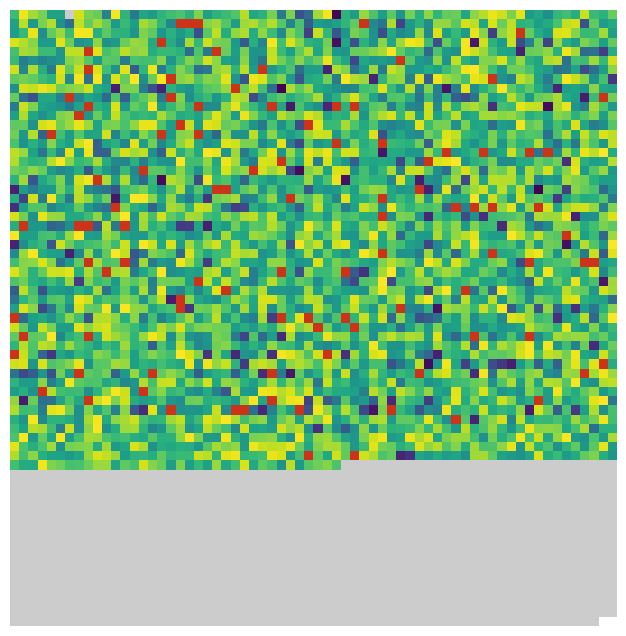

['00:15', '00:30', '00:45', '01:00', '01:15', '01:30', '01:45', '02:00', '02:15', '02:30', '02:45', '03:00', '03:15', '03:30', '03:45', '04:00', '04:15', '04:30', '04:45', '05:00', '05:15', '05:30', '05:45', '06:00', '06:15', '06:30', '06:45', '07:00', '07:15', '07:30', '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '09:15', '09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00', '11:15', '11:30', '11:45', '12:00', '12:15', '12:30', '12:45', '13:00', '13:15', '13:30', '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00', '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45', '20:00', '20:15', '20:30', '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15', '22:30', '22:45', '23:00', '23:15', '23:30', '23:45']


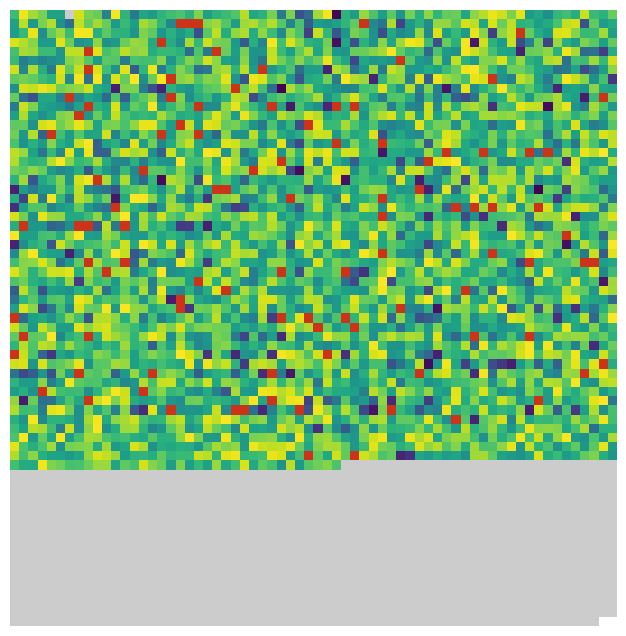

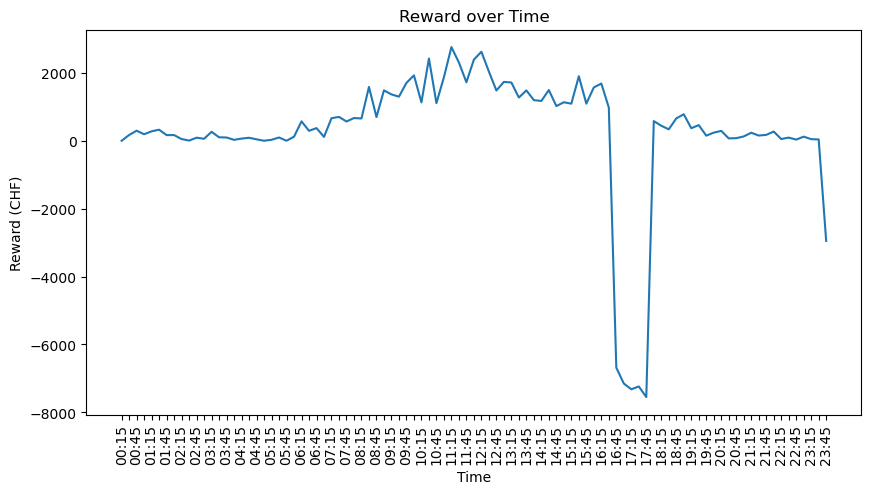

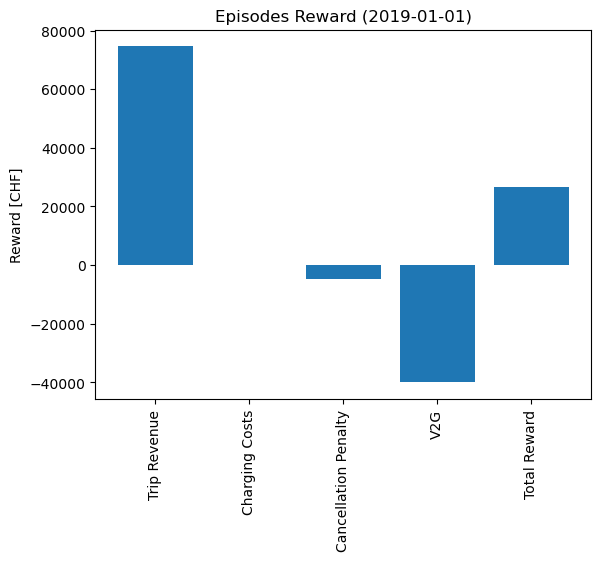


Total Episode Time:  43.31162214279175



In [154]:
# number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0

# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)
    
    sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_reservations = pd.read_sql(sql, engine)
    
    sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_durations = pd.read_sql(sql, engine)
        
    # iteration for each day
    for day in range(98,676,96):
        start = time.time()
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date = pd.to_datetime(data.columns[day-97])
       
        # load reservations of current day, create indices
        sql = "SELECT * FROM msc_2023_dominik.reservations_discrete WHERE reservationfrom_discrete_date = '{}' or drive_firststart_discrete_date = '{}' ORDER BY reservationfrom_discrete".format(date, date)
        reservations = pd.read_sql(sql, engine)
        reservations.set_index(['vehicle_no', 'reservationfrom_daytime', 'syscreatedate_daytime'], inplace=True, drop=False)

        # get discete data of day
        daily_data = data.iloc[:,day-97:day]
        planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
        planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 
        
        
        # reset day at begining of new episode (day)
        s = env.reset(daily_data, reservations, planned_reservations_day, planned_durations_day)
        
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            # get your action 
            act = your_v2g_strategy(s, nr_vehicles)

            # proceed one time step
            s, rew, daily_data, done, _ = env.step(act, daily_data, reservations, electricity_price, planned_reservations_day, planned_durations_day)
            
            # get timestep statistics 
            env.render(daily_data)
            
            #print("Reward in this step:", rew, " time: ", env.t)
            counter +=1
        end = time.time()
        # summary statistics of episode (day)
        env.episode_summary_statistics(daily_data)
        print("")
        print("Total Episode Time: ", end-start)
        print("")
        count += 1